In [1]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
from common.utils import*
from common.networks import*


### LOAD DATA

In [3]:
mat = scipy.io.loadmat('./binaryalphadigs.mat')
arrays_list = [ lire_alpha(mat['dat'],i) for i in range(1)]
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
test = np.concatenate(arrays_list, axis=0)
np.random.shuffle(test)
print(test.shape)

(39, 320)


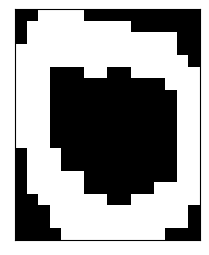

In [4]:
plt.figure(figsize=(3,3))
plt.xticks([])
plt.yticks([])
plt.imshow(test[0].reshape(20,16),cmap='gray')

# Test RBM - ALPHADigits

### First on one digit

**We will train the rbm for 1000 epochs and a batch size of 15 and perform only one gibbs sampling**

In [6]:
input_size = test.shape[1]
hidden_size = 100
rbm = RBM(input_size,hidden_size,device)
digits_test = torch.tensor(test).float().to(device) # convert to tensor
rbm.train(data=digits_test,n_steps=1000,alpha=0.1,mode="batch",batch_size=15,k=1) 

**Now we test if we can reconstruct an image**

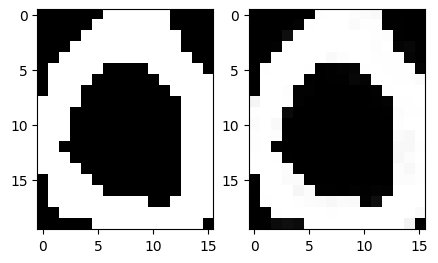

In [8]:
idx = np.random.randint(0,test.shape[0])
pic = torch.tensor(test[idx]).float().to(device)
b = rbm.forward(pic) # entree sortie
p = rbm.backward(b) # sortie entree
plt.figure(figsize=(5,5))
plt.subplot(1,2,1)
plt.imshow(pic.detach().cpu().numpy().reshape(20,16),cmap='gray')
plt.subplot(1,2,2)
plt.imshow(p.detach().cpu().numpy().reshape(20,16),cmap='gray')

**Perfect we were able to reconstruct an image. Now we will test the generation performance**

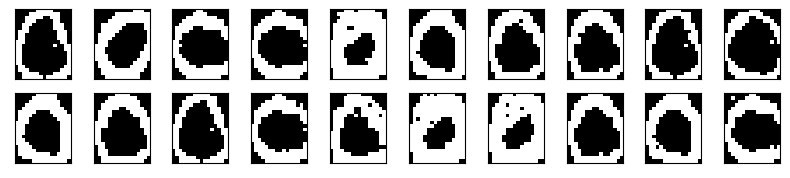

In [9]:
gen = rbm.generate(20,1000) # we generate 20 images and perform 100 gibbs sampling
plt.figure(figsize=(10,2))
for i in range(20):
    plt.subplot(2,10,i+1)
    plt.imshow(gen[i].detach().cpu().numpy().reshape(20,16),cmap='gray')
    plt.xticks([]),plt.yticks([])

**For now our model can reconstruct and generate samples for digit 0. Now we will test with more digits**

### With 5 digits

In [10]:
arrays_list = [ lire_alpha(mat['dat'],i) for i in range(5)]
test = np.concatenate(arrays_list, axis=0)
np.random.shuffle(test)
print(test.shape)

(195, 320)


In [11]:
input_size = test.shape[1]
hidden_size = 100
rbm = RBM(input_size,hidden_size,device)
digits_test = torch.tensor(test).float().to(device) # convert to tensor
rbm.train(data=digits_test,n_steps=1000,alpha=0.1,mode="batch",batch_size=100,k=1) 

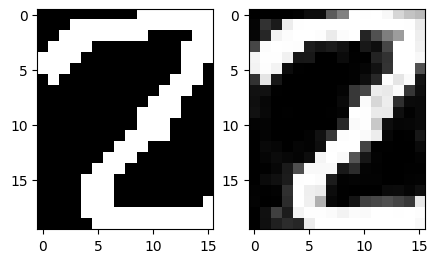

In [17]:
idx = np.random.randint(0,test.shape[0])
pic = torch.tensor(test[idx]).float().to(device)
b = rbm.forward(pic) # entree sortie
p = rbm.backward(b) # sortie entree
plt.figure(figsize=(5,5))
plt.subplot(1,2,1)
plt.imshow(pic.detach().cpu().numpy().reshape(20,16),cmap='gray')
plt.subplot(1,2,2)
plt.imshow(p.detach().cpu().numpy().reshape(20,16),cmap='gray')

**We are able to reconstruct digit 2**

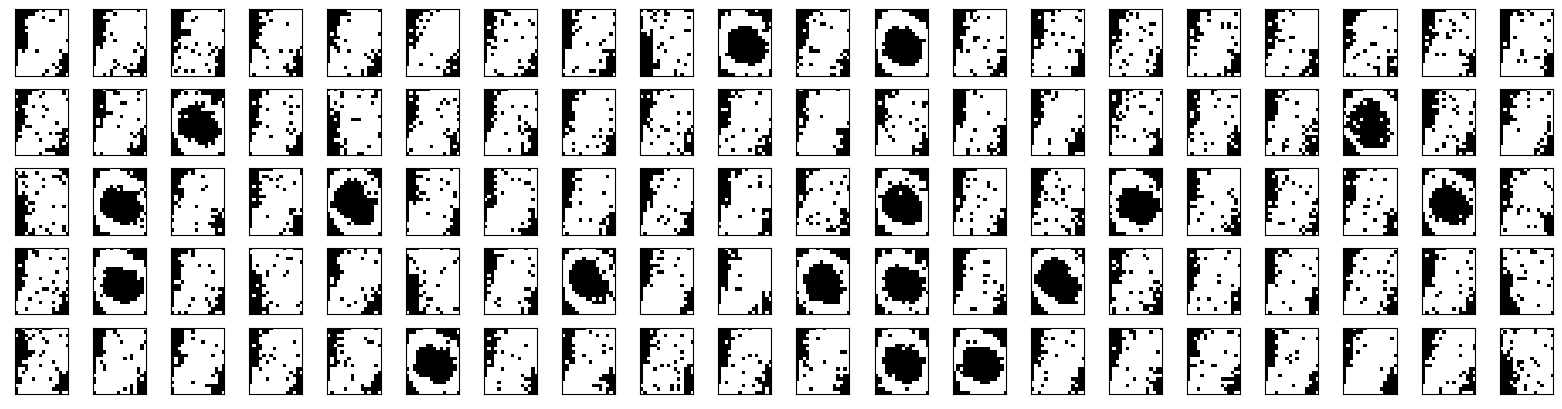

In [18]:
gen = rbm.generate(100,1000) # we generate 100 images and perform 1000 gibbs sampling
plt.figure(figsize=(20,5))
for i in range(100):
    plt.subplot(5,20,i+1)
    plt.imshow(gen[i].detach().cpu().numpy().reshape(20,16),cmap='gray')
    plt.xticks([]),plt.yticks([])

**The digit 0 is being well generated .The digit 1 less and the digit 2 not  well**

Now will test the DBN

# TEST DBN ALPHADigits

In [19]:
arrays_list = [ lire_alpha(mat['dat'],i) for i in range(10)] # we charge all the digits
test = np.concatenate(arrays_list, axis=0)
np.random.shuffle(test)
print(test.shape)

(390, 320)


In [20]:
# init the DBN with 3 layers 
hidden_sizes = [64,128,256]
input_size = test.shape[1]
dbn = DBN(input_size,hidden_sizes,device)
digits_test = torch.tensor(test).float().to(device)
# we train for 2000 epochs with a batchsize of 128 and perform 1 gibbs sampling
dbn.train(data=digits_test,n_steps=2000,alpha=1e-1,mode="batch",batch_size=128,k=1)

100%|██████████| 3/3 [06:35<00:00, 131.67s/it]


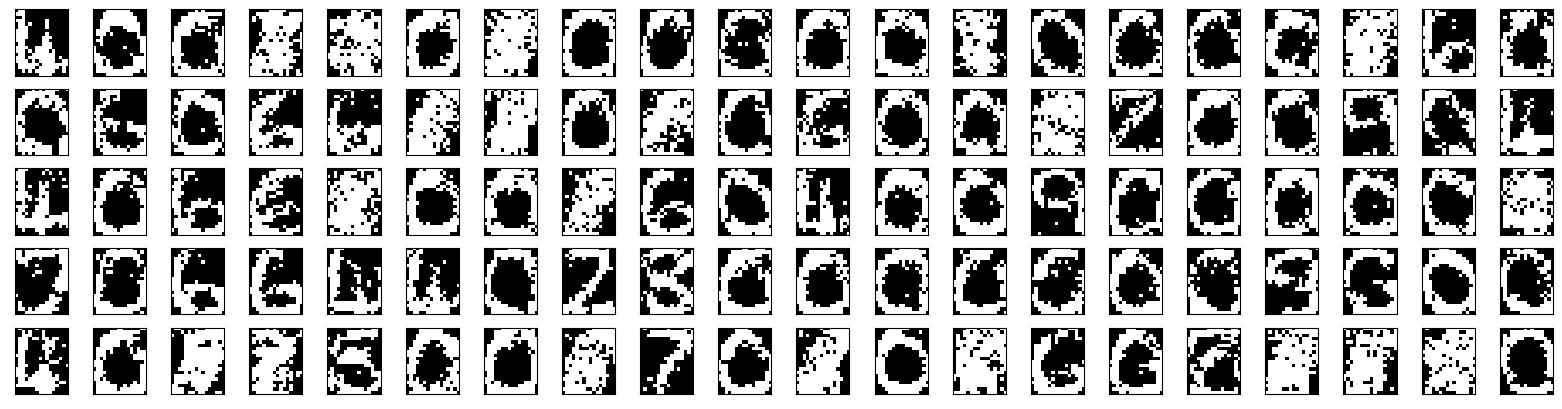

In [22]:
gen2 = dbn.generate(100,1000) # we generate 100 samples and perform 100 gibbs sampling
plt.figure(figsize=(20,5))
for i in range(100):
    plt.subplot(5,20,i+1)
    plt.imshow(gen2[i].detach().cpu().numpy().reshape(20,16),cmap='gray')
    plt.xticks([])
    plt.yticks([])

**The digits are more well generated with a DBN**

# TEST DNN - MNIST

In [23]:
# Create a DataLoader
train_dataset,test_dataset = load_mnist(2000) # first we load 2000 random digits for the training
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

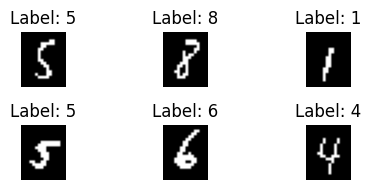

In [24]:
images, labels = next(iter(train_loader))
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(5, 2))
for i, ax in enumerate(axes.flat):
    img = images[i].squeeze() #
    ax.imshow(img.reshape(20,16), cmap='gray') 
    ax.set_title(f'Label: {labels[i].item()}') 
    ax.axis('off') 

plt.tight_layout() # Ajuster automatiquement les sous-plots pour qu'ils s'insèrent dans la figure
plt.show()

### Pretraining

In [26]:
hidden_sizes = [100,100,100]
num_classes = 10
input_size = test.shape[1]
model = DNN(input_size,hidden_sizes,num_classes,device)
digits_test = torch.tensor(test).float().to(device)
model.pretrain(digits_test,n_steps=2000,alpha=1e-1,mode="batch",batch_size=32,k=1) # we pretrain the DNN  for 2000 epochs and a batch of 32

100%|██████████| 3/3 [01:41<00:00, 33.71s/it]


**Now we train the DNN on a supervised manner for 50 epochs**

In [28]:
model = model.to(device)
model.train(dataloader=train_loader,n_epochs=100,lr=1e-3)

100%|██████████| 100/100 [00:36<00:00,  2.75it/s]


In [29]:
model.evaluate(test_loader) # we evaluate on the test

0.8721